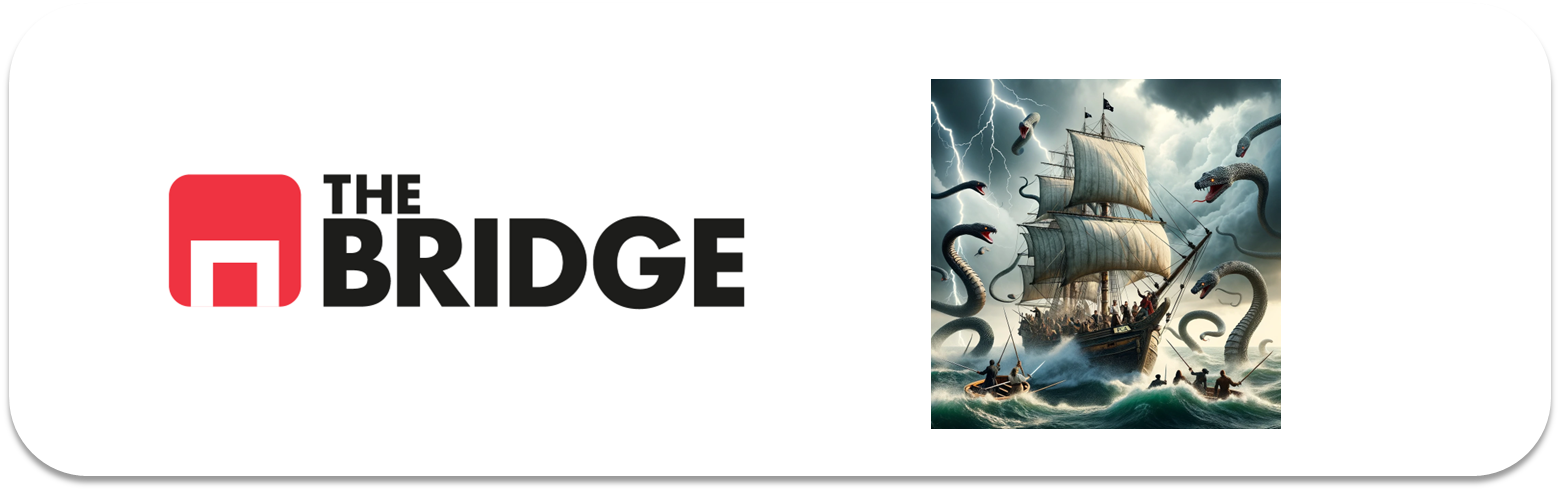

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

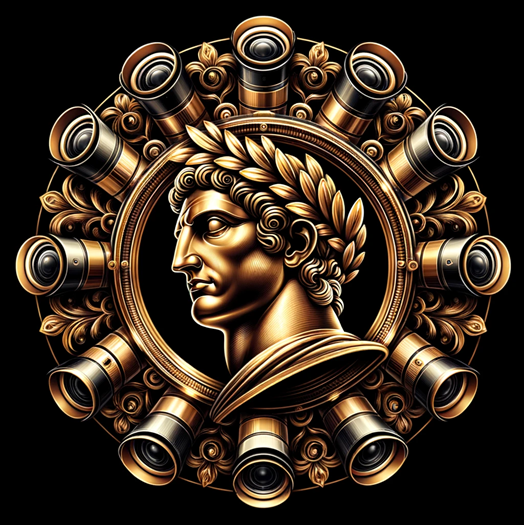

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [3]:

# --------------------------------------------------------------------------------
# #1 MODELO BASE
# --------------------------------------------------------------------------------

# 1. Descarga del dataset de caras de Olivetti (sklearn)
#    Este dataset contiene 400 imágenes de 64x64 píxeles (total de 4096 features),
#    con 40 caras (10 imágenes por persona).
data, target = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=42)

# 2. Construcción de un DataFrame (OPCIONAL para visualizaciones o EDA)
df = pd.DataFrame(data)
df['target'] = target

# 3. Split en train y test con al menos 80 instancias en test y estratificado según el target
#    (cada persona aparece estratificadamente en ambos subconjuntos).
#    Olivetti tiene 400 imágenes. Escogemos test_size=80.
X_train, X_test, y_train, y_test = train_test_split(
    data, target, 
    test_size=80, 
    stratify=target, 
    random_state=42
)

# 4. (Opcional) Mini EDA
#    Aquí podríamos chequear cosas como la dimensión, la distribución de clases, etc.
#    Dado que es un dataset conocido y pequeño, podemos omitir un EDA detallado.

# 5. Construimos un modelo base y calculamos la balanced_accuracy sobre CV y test
clf_base = RandomForestClassifier(random_state=42)

# Cross-validation (5 folds)
scores_cv_base = cross_val_score(
    clf_base, X_train, y_train, 
    cv=5, 
    scoring='balanced_accuracy'
)
baseline_cv = scores_cv_base.mean()

# Entrenamos con todo el training set y evaluamos en test
clf_base.fit(X_train, y_train)
y_pred_test_base = clf_base.predict(X_test)
baseline_test = balanced_accuracy_score(y_test, y_pred_test_base)

print("=== MODELO BASELINE ===")
print(f"Balanced Accuracy en CV (5 folds): {baseline_cv:.4f}")
print(f"Balanced Accuracy en Test:        {baseline_test:.4f}")

# Guardamos estas métricas como baseline
# --------------------------------------------------------------------------------



=== MODELO BASELINE ===
Balanced Accuracy en CV (5 folds): 0.9325
Balanced Accuracy en Test:        0.9500


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [4]:
# --------------------------------------------------------------------------------
# #2 MODELO PARA LAS MICROCÁMARAS (PCA como compresión directa para clasificar)
# --------------------------------------------------------------------------------

# Objetivo: probar distintos números de componentes PCA que supongan
#           entre el 0.2% y el 2.5% del tamaño original (4096).
#           0.2% de 4096 ≈ 8.2 => ~8
#           2.5% de 4096 ≈ 102.4 => ~100
# Probaremos por ejemplo 5 valores de n_componentes en ese rango.

pca_n_components_list = [8, 20, 50, 80, 100]

resultados_pca = []

for n_comp in pca_n_components_list:
    # 1. Instanciamos PCA y ajustamos con X_train
    pca = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca  = pca.transform(X_test)
    
    # 2. Entrenamos un clasificador (usamos de nuevo RandomForest)
    clf = RandomForestClassifier(random_state=42)
    
    # 3. Validación cruzada sobre train (5 folds) usando las features comprimidas
    scores_cv = cross_val_score(clf, X_train_pca, y_train, 
                                cv=5, scoring='balanced_accuracy')
    mean_cv_score = scores_cv.mean()
    
    # 4. Entrenamos sobre todo el train comprimido y medimos en test comprimido
    clf.fit(X_train_pca, y_train)
    y_pred_test = clf.predict(X_test_pca)
    mean_test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    # Cálculo de la compresión (%)
    #   Si antes teníamos 4096 features, ahora tenemos n_comp.
    #   La "ratio" de compresión es (n_comp / 4096).
    #   Expresado en % => (n_comp / 4096)*100
    compression_percentage = (n_comp / 4096) * 100
    
    # Diferencias respecto al baseline (en puntos porcentuales)
    diff_cv  = (mean_cv_score - baseline_cv) * 100
    diff_test = (mean_test_score - baseline_test) * 100
    
    resultados_pca.append({
        "n_components": n_comp,
        "cv_score": mean_cv_score,
        "test_score": mean_test_score,
        "compression_%": compression_percentage,
        "diff_cv_vs_base(pts)": diff_cv,
        "diff_test_vs_base(pts)": diff_test
    })

df_pca_resultados = pd.DataFrame(resultados_pca)
print("\n=== RESULTADOS PCA (COMPRESIÓN PARA MICROCÁMARAS) ===")
print(df_pca_resultados)

# 5. Escoger el número de componentes que permita mayor compresión 
#    con una pérdida < 3 puntos (o si no < 5 puntos).
#    Para no perder más de 3 puntos, necesitamos que:
#    - diff_cv_vs_base(pts) >= -3
#    - diff_test_vs_base(pts) >= -3
mask_3pts = (
    (df_pca_resultados["diff_cv_vs_base(pts)"] >= -3) &
    (df_pca_resultados["diff_test_vs_base(pts)"] >= -3)
)
candidatos_3pts = df_pca_resultados[mask_3pts]

if len(candidatos_3pts) > 0:
    # Queremos la mayor compresión => menor n_components
    # (o equivalentemente mayor 'compression_%' es mayor, pero preferimos
    #  directamente buscar el n_components más pequeño).
    mejor_3pts = candidatos_3pts.sort_values("n_components").iloc[0]
    print("\nCandidato con pérdida < 3 puntos:")
    print(mejor_3pts)
else:
    # Si no existe con < 3 puntos, mirar < 5 puntos
    mask_5pts = (
        (df_pca_resultados["diff_cv_vs_base(pts)"] >= -5) &
        (df_pca_resultados["diff_test_vs_base(pts)"] >= -5)
    )
    candidatos_5pts = df_pca_resultados[mask_5pts]
    if len(candidatos_5pts) > 0:
        mejor_5pts = candidatos_5pts.sort_values("n_components").iloc[0]
        print("\nCandidato con pérdida < 5 puntos:")
        print(mejor_5pts)
    else:
        print("\nNo hay ningún PCA que pierda menos de 5 puntos porcentuales.")    


=== RESULTADOS PCA (COMPRESIÓN PARA MICROCÁMARAS) ===
   n_components  cv_score  test_score  compression_%  diff_cv_vs_base(pts)  \
0             8     0.790      0.8375       0.195312                -14.25   
1            20     0.905      0.9375       0.488281                 -2.75   
2            50     0.935      0.9125       1.220703                  0.25   
3            80     0.905      0.9375       1.953125                 -2.75   
4           100     0.885      0.9250       2.441406                 -4.75   

   diff_test_vs_base(pts)  
0                  -11.25  
1                   -1.25  
2                   -3.75  
3                   -1.25  
4                   -2.50  

Candidato con pérdida < 3 puntos:
n_components              20.000000
cv_score                   0.905000
test_score                 0.937500
compression_%              0.488281
diff_cv_vs_base(pts)      -2.750000
diff_test_vs_base(pts)    -1.250000
Name: 1, dtype: float64


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [5]:
# --------------------------------------------------------------------------------
# #3 COMPRESIÓN PARA CLASIFICACIÓN POSTERIOR (en el servidor, usando inverse_transform)
# --------------------------------------------------------------------------------

# Ahora se comprimen las imágenes con PCA pero se descomprimen (inverse_transform)
# antes de clasificarlas. Se busca un rango de valores con compresión entre
# 0.1% (aprox) y 1% del tamaño original.
# 0.1% de 4096 = ~4
# 1%   de 4096 = ~40

pca_n_components_list_2 = [4, 8, 16, 32, 40]

resultados_pca_unzipped = []
for n_comp in pca_n_components_list_2:
    pca = PCA(n_components=n_comp, random_state=42)
    # Ajustamos la PCA solo con X_train
    X_train_pca = pca.fit_transform(X_train)
    
    # "Descomprimimos" el set de entrenamiento
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    
    # Entrenamos el clasificador con los datos "descomprimidos"
    clf = RandomForestClassifier(random_state=42)
    
    # Para ver la bondad en CV podríamos hacer cross_val_score, 
    # pero lo más directo es entrenar y medir en test.
    # Aun así, si se quiere CV también habría que regenerar X con folds.
    # Aquí haremos solo entrenar con el train entero y medir en test.
    clf.fit(X_train_unzipped, y_train)
    
    # Descomprimimos también X_test
    X_test_unzipped = pca.inverse_transform(pca.transform(X_test))
    
    # Predecimos sobre test "descomprimido"
    y_pred = clf.predict(X_test_unzipped)
    score_test_unzipped = balanced_accuracy_score(y_test, y_pred)
    
    compression_percentage = (n_comp / 4096) * 100
    diff_test_unzipped = (score_test_unzipped - baseline_test) * 100
    
    resultados_pca_unzipped.append({
        "n_components": n_comp,
        "test_score_unzipped": score_test_unzipped,
        "compression_%": compression_percentage,
        "diff_test_vs_base(pts)": diff_test_unzipped
    })

df_pca_unzipped = pd.DataFrame(resultados_pca_unzipped)
print("\n=== RESULTADOS PCA INVERSE (COMPRESIÓN PARA PROCESO POSTERIOR) ===")
print(df_pca_unzipped)

# Escoger el número de PCA que no pierda más de 3 puntos porcentuales 
# con respecto al baseline.
mask_3pts_unzipped = df_pca_unzipped["diff_test_vs_base(pts)"] >= -3
candidatos_unzipped_3pts = df_pca_unzipped[mask_3pts_unzipped]

if len(candidatos_unzipped_3pts) > 0:
    mejor_unzipped_3pts = candidatos_unzipped_3pts.sort_values("n_components").iloc[0]
    print("\nCandidato (compresión -> inverse_transform) con pérdida < 3 puntos:")
    print(mejor_unzipped_3pts)
else:
    print("\nNo se encontró ningún PCA con pérdida < 3 puntos en inverse_transform.")


=== RESULTADOS PCA INVERSE (COMPRESIÓN PARA PROCESO POSTERIOR) ===
   n_components  test_score_unzipped  compression_%  diff_test_vs_base(pts)
0             4               0.6500       0.097656                  -30.00
1             8               0.8375       0.195312                  -11.25
2            16               0.9125       0.390625                   -3.75
3            32               0.9125       0.781250                   -3.75
4            40               0.9125       0.976562                   -3.75

No se encontró ningún PCA con pérdida < 3 puntos en inverse_transform.


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

C:\Users\juanmoreno\AppData\Local\Temp\ipykernel_24500\940058406.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap('tab20', 10)


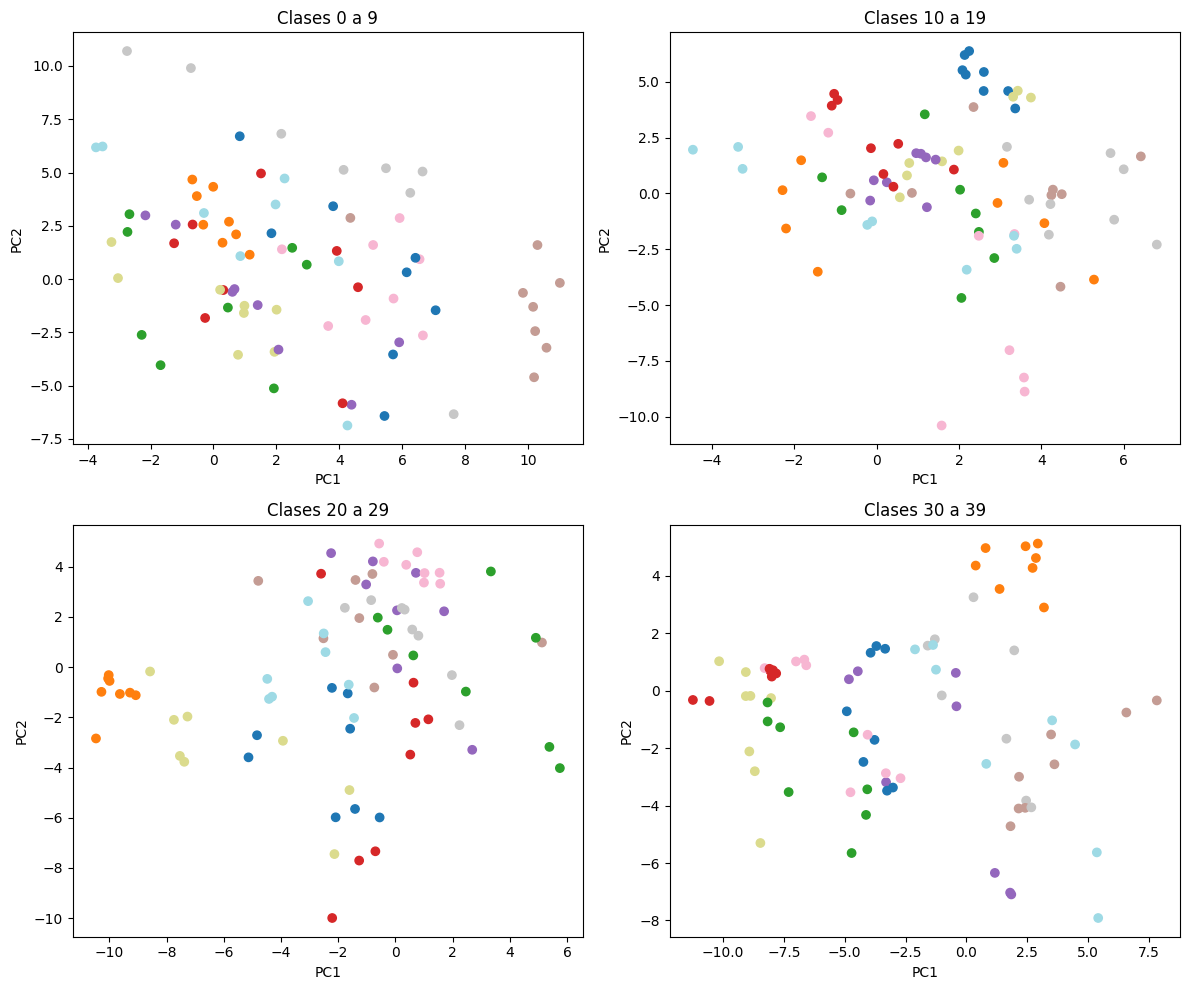


Mostrando comparación para PCA con 4 componentes:


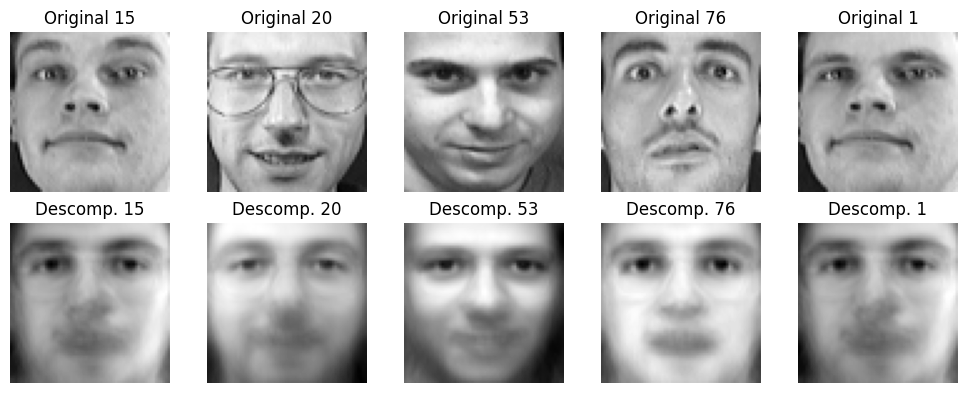


Mostrando comparación para PCA con 8 componentes:


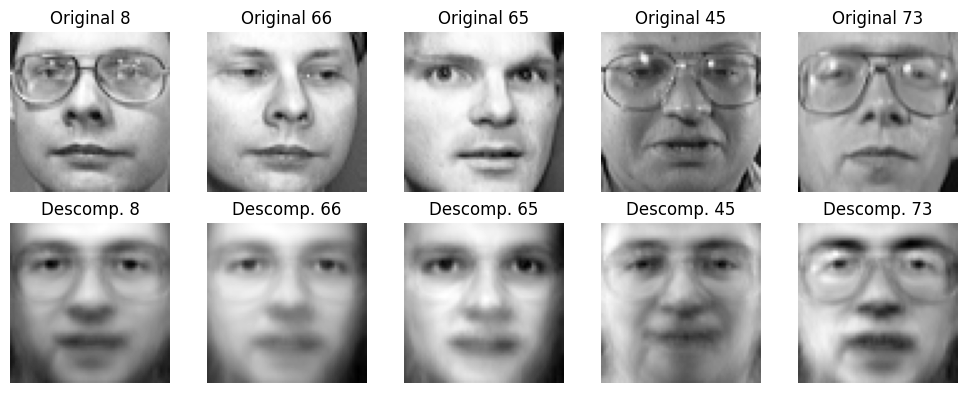


Mostrando comparación para PCA con 16 componentes:


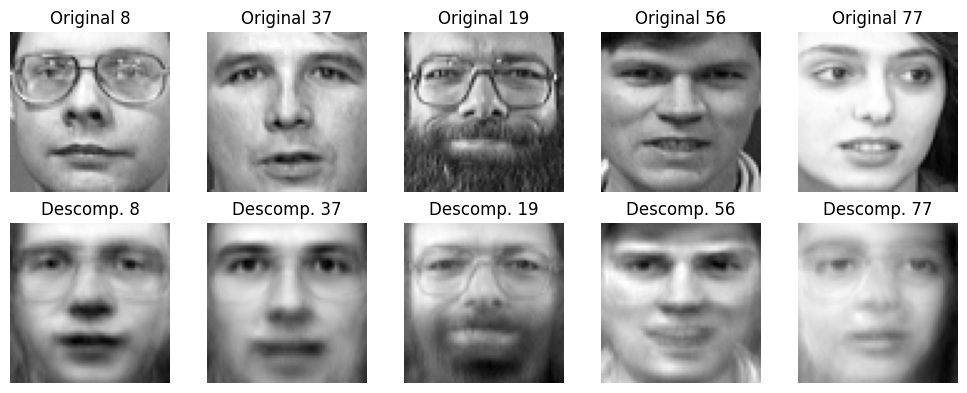


Mostrando comparación para PCA con 32 componentes:


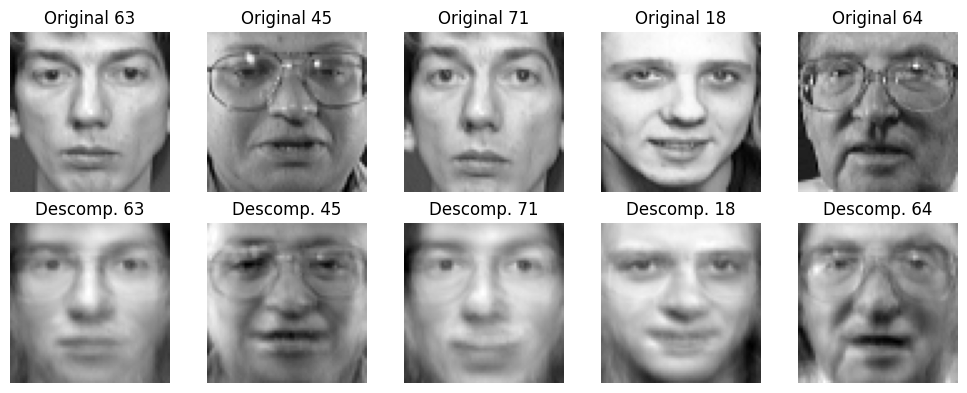


Mostrando comparación para PCA con 40 componentes:


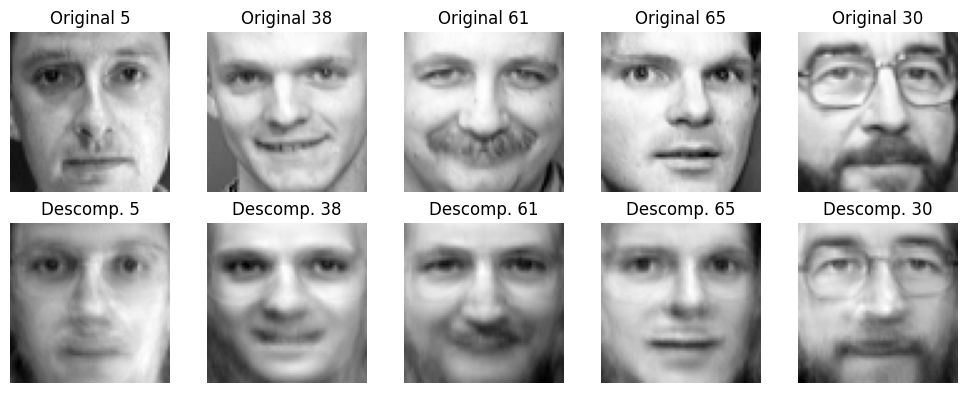


Mostrando comparación para PCA con 150 componentes:


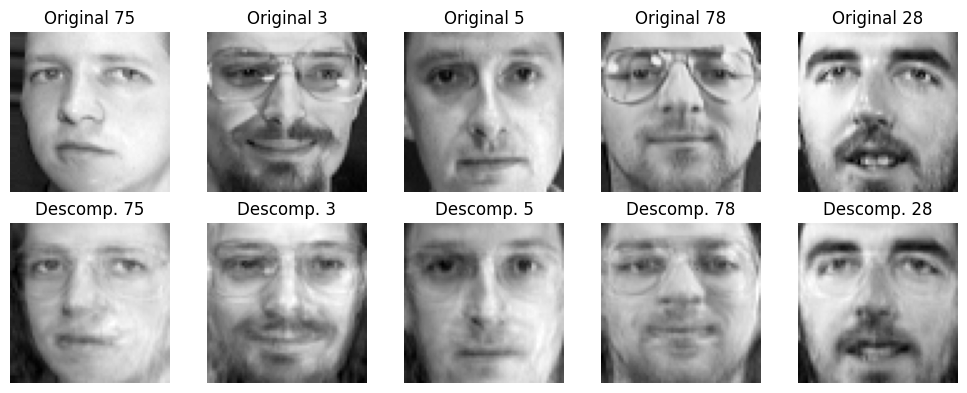


Mostrando comparación para PCA con 300 componentes:


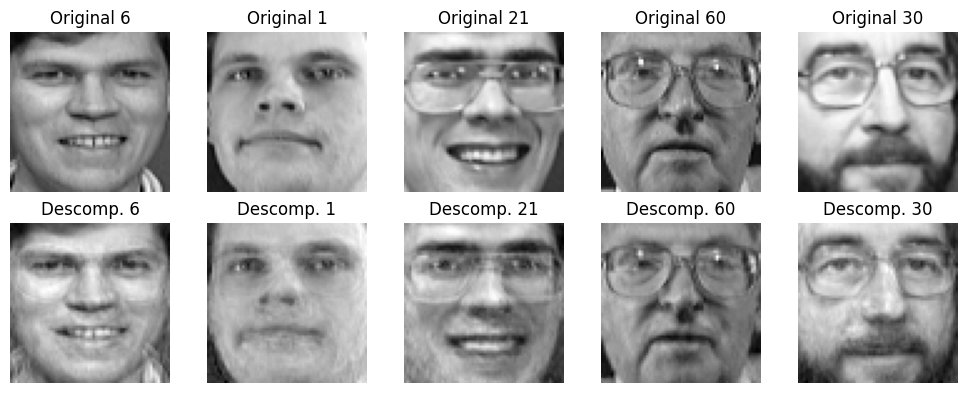

In [6]:

# --------------------------------------------------------------------------------
# #EXTRA
# --------------------------------------------------------------------------------
# 1. Visualizar en cuatro gráficos scatter de las dos primeras componentes principales
#    de la PCA elegida en la parte 2. Supongamos que elegimos por ejemplo n_comp = 50
#    (o la que hayamos considerado 'mejor') para ilustrar.

import matplotlib.cm as cm

n_comp_demo = 50
pca_demo = PCA(n_components=n_comp_demo, random_state=42)
X_train_pca_demo = pca_demo.fit_transform(X_train)

# Tomamos solo las dos primeras componentes para scatter plot
x_pca_2d = X_train_pca_demo[:, :2]
y_pca = y_train

# Como hay 40 clases (0 a 39), las dividimos de 10 en 10
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Cada subplot tendrá 10 clases
    clase_inicial = i*10
    clase_final = clase_inicial + 10
    mask = (y_pca >= clase_inicial) & (y_pca < clase_final)
    
    scatter = ax.scatter(
        x_pca_2d[mask, 0],
        x_pca_2d[mask, 1],
        c=y_pca[mask],
        cmap=cm.get_cmap('tab20', 10)
    )
    ax.set_title(f"Clases {clase_inicial} a {clase_final-1}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    
plt.tight_layout()
plt.show()

# 2. Función para visualizar la cara original vs. cara después de inverse_transform.
from math import ceil

def mostrar_comparativa(X_original, pca, num_imgs=5):
    """
    Muestra num_imgs caras originales y la versión comprimida+descomprimida.
    X_original: array con forma (n_muestras, 4096)
    pca: objeto PCA ya ajustado
    num_imgs: cuántas caras (al azar) mostrar
    """
    indices = np.random.choice(range(X_original.shape[0]), size=num_imgs, replace=False)
    X_comprimido = pca.transform(X_original[indices])
    X_descomprimido = pca.inverse_transform(X_comprimido)
    
    fig, axes = plt.subplots(2, num_imgs, figsize=(2*num_imgs, 4))
    for i, idx in enumerate(indices):
        # Original
        axes[0, i].imshow(X_original[idx].reshape(64, 64), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {idx}")
        
        # Descomprimida
        axes[1, i].imshow(X_descomprimido[i].reshape(64, 64), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Descomp. {idx}")
    plt.tight_layout()
    plt.show()

# Probamos la visualización para los diferentes n_componentes utilizados en la parte 3,
# por ejemplo, 4, 8, 16, 32, 40, y añadimos 150 y 300 como menciona el enunciado extra.
pca_values_to_show = [4, 8, 16, 32, 40, 150, 300]
for val in pca_values_to_show:
    print(f"\nMostrando comparación para PCA con {val} componentes:")
    pca_show = PCA(n_components=val, random_state=42).fit(X_train)
    mostrar_comparativa(X_test, pca_show, num_imgs=5)
